In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
path = Path.cwd().parents[0]
if str(path) not in sys.path:
    sys.path.append(str(path))

In [2]:
# Imports
trials = 50
n=500
front_door = True
minimise = False

results_kl = torch.load(path / "causalklgp/simulation_causalklgp_ntrial={0}_n={1}_frontdoor={2}_minimise={3}_addbase=True.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
results_bimp = torch.load(path / "bayesimp/simulation_bayesimp_ntrial={0}_n={1}_frontdoor={2}_minimise={3}_addbase=True.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
results_bgp = torch.load(path / "baseline/simulation_baseline_ntrial={0}_n={1}_frontdoor={2}_minimise={3}.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
results_bo = torch.load(path / "naivebo/simulation_naivebo_ntrial={0}_n={1}_frontdoor={2}_minimise={3}.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
# Getting dimensions and names
levels = results_kl[0]['cal_levels']
n_level = len(levels)
n_result_kl = len(results_kl)
n_model_kl = int(n_result_kl/trials)
n_result_bimp = len(results_bimp)
n_model_bimp = int(n_result_bimp/trials)
n_result_bgp = len(results_bgp)
n_model_bgp = int(n_result_bgp/trials)
n_result_bo = len(results_bo)
n_model_bo = int(n_result_bo/trials)
names = []

In [3]:
results = [results_bo, results_bgp,results_bimp,results_kl]
n_model = [n_model_bo, n_model_bgp, n_model_bimp, n_model_kl]

In [4]:
EYdoX_eval_kl = torch.zeros((len(results_kl[0]['EYdoXeval']), trials, n_model_kl))
EYdoX_eval_bimp = torch.zeros((len(results_bimp[0]['EYdoXeval']), trials, n_model_bimp))
EYdoX_eval_bgp = torch.zeros((len(results_bgp[0]['EYdoXeval']), trials, n_model_bgp))
EYdoX_eval_bo = torch.zeros((len(results_bo[0]['EYdoXeval']), trials, n_model_bo))

EYdoX_eval = [EYdoX_eval_bo,EYdoX_eval_bgp,EYdoX_eval_bimp,EYdoX_eval_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
            for t in range(trials):
                EYdoX_eval[r][:,t,m] = results[r][trials*m + t]['EYdoXeval'][:,0]

In [5]:
doX_eval_kl = torch.zeros((len(results_kl[0]['doXeval']), trials, n_model_kl))
doX_eval_bimp = torch.zeros((len(results_bimp[0]['doXeval']), trials, n_model_bimp))
doX_eval_bgp = torch.zeros((len(results_bgp[0]['doXeval']), trials, n_model_bgp))
doX_eval_bo = torch.zeros((len(results_bo[0]['doXeval']), trials, n_model_bo))

doX_eval = [doX_eval_bo,doX_eval_bgp,doX_eval_bimp,doX_eval_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
            for t in range(trials):
                doX_eval[r][:,t,m] = results[r][trials*m + t]['doXeval'][:,0]

In [6]:
# Getting best values
iters = len(results_kl[0]['EYdoXeval'])
best_eval_bo = torch.zeros((iters, trials, n_model_bo))
best_eval_bgp = torch.zeros((iters, trials, n_model_bgp))
best_eval_bimp = torch.zeros((iters, trials, n_model_bimp))
best_eval_kl = torch.zeros((iters, trials, n_model_kl))

best_eval = [best_eval_bo,best_eval_bgp,best_eval_bimp, best_eval_kl]

# Getting best values
for m in range(len(n_model)):
    for t in range(trials):
        for i in range(iters):
            if i == 0:
                best_eval[m][i,t] = EYdoX_eval[m][i,t] 
            else:
                if minimise:
                    if EYdoX_eval[m][i,t] < best_eval[m][:i,t].min():
                        best_eval[m][i,t] = EYdoX_eval[m][i,t]
                    else:
                         best_eval[m][i,t] =  best_eval[m][i-1,t]
                else:
                    if EYdoX_eval[m][i,t] > best_eval[m][:i,t].max():
                        best_eval[m][i,t] = EYdoX_eval[m][i,t]
                    else:
                         best_eval[m][i,t] =  best_eval[m][i-1,t]

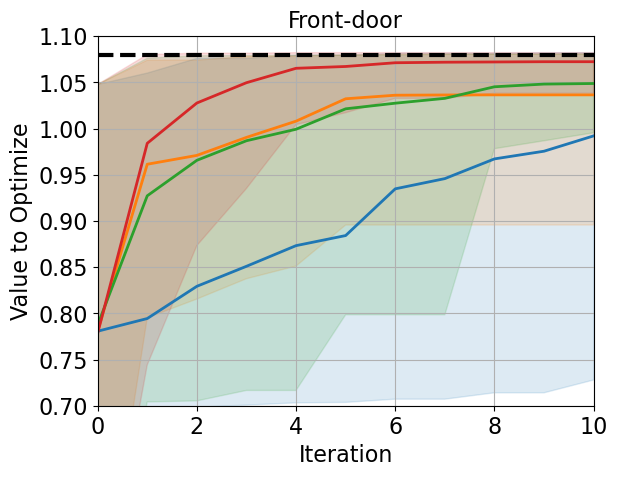

In [7]:
i = 11
# Define names for the methods
names = ["BO", "CBO", "BayesIMP", "CausalKLGP"]

# Get the default color cycle from Matplotlib
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Start plotting
for r in range(len(n_model)):
    color = colors[r % len(colors)]  # Use r-th color from the default color cycle
    plt.plot(best_eval[r].mean(1)[:i], label=names[r], lw=2.0, ls="solid", color=color)
    plt.fill_between(
        torch.arange(min(len(best_eval[r]), i)),
        best_eval[r].quantile(0.95, 1)[:i, 0],
        best_eval[r].quantile(0.05, 1)[:i, 0],
        alpha=0.15,
        color=color  # Match the fill color with the plot color
    )

# Add a horizontal line at the maximum value of 'int_data'
plt.axhline(torch.max(results_kl[0]['int_data'][1]), color="black", ls="dashed", lw=3.0)

# Add grid, set limits, and adjust tick sizes
plt.grid()
plt.xlim(0, 10)
plt.ylim(0.7,1.10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add legend, labels, and title with specified font size
#plt.legend(fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Value to Optimize", fontsize=16)
plt.title("Front-door", fontsize=16)

# Save the plot with tight bounding box
plt.savefig("CBO_convergence_profile_fd", bbox_inches="tight")

# Show the plot
plt.show()

In [8]:
# Saving results
torch.save(obj = [best_eval, torch.max(results_kl[0]['int_data'][1])],
           f = "fd_best_evals.pt")

In [3]:
# RMSE table
rmse_kl = torch.zeros(len(results_kl))
rmse_bimp = torch.zeros(len(results_bimp))
rmse_bgp = torch.zeros(len(results_bgp))

for i in range(len(results_kl)):
    rmse_kl[i] = results_kl[i]['rmse']
for i in range(len(results_bimp)):
    rmse_bimp[i] = results_bimp[i]['rmse']
for i in range(len(results_bgp)):
    rmse_bgp[i] = results_bgp[i]['rmse']

    
rmse_kl = rmse_kl.reshape(n_model_kl,trials).T
rmse_bimp = rmse_bimp.reshape(n_model_bimp,trials).T
rmse_bgp = rmse_bgp.reshape(n_model_bgp,trials).T

print(rmse_kl.mean(0), rmse_kl.var(0)**0.5/trials**0.5)
print(rmse_bimp.mean(0), rmse_bimp.var(0)**0.5/trials**0.5)
print(rmse_bgp.mean(0), rmse_bgp.var(0)**0.5/trials**0.5)

tensor([0.2820]) tensor([0.0173])
tensor([0.2312]) tensor([0.0125])
tensor([0.2173]) tensor([0.0096])


tensor([0.0153])
tensor([0.0786])
tensor([0.1340])


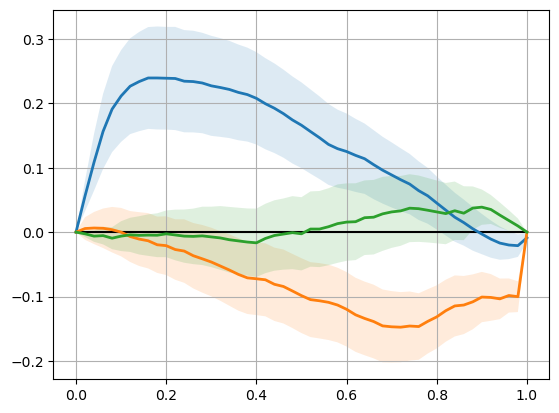

In [4]:
# Getting calibration curves
z = 1.645

plot_inds = 2*torch.arange(51)

post_levels_kl = torch.zeros(len(results_kl),n_level)
post_levels_bimp = torch.zeros(len(results_bimp),n_level)
post_levels_bgp = torch.zeros(len(results_bgp),n_level)

for i in range(len(results_kl)):
    post_levels_kl[i] =  results_kl[i]['post_levels'].mean(0)
for i in range(len(results_bimp)):
    post_levels_bimp[i] =  results_bimp[i]['post_levels'].mean(0)
for i in range(len(results_bgp)):
    post_levels_bgp[i] =  results_bgp[i]['post_levels'].mean(0)
    
post_levels_kl = post_levels_kl.reshape(n_model_kl,trials,n_level)
post_levels_bimp = post_levels_bimp.reshape(n_model_bimp,trials,n_level)
post_levels_bgp = post_levels_bgp.reshape(n_model_bgp,trials,n_level)

plt.plot(levels,levels - levels, color = "black")
model_inds = [[0],[0],[0]]

l =levels[plot_inds,0]
for i in range(n_model_bgp):
     if i in model_inds[2]:
         plt.plot(l,post_levels_bgp.mean(1).T[plot_inds,i] - l, lw = 2.0);
         plt.fill_between(levels[plot_inds][:,0],
                     post_levels_bgp.mean(1).T[plot_inds,...,i] - z*post_levels_bgp.var(1).T[plot_inds,...,i]**0.5/trials**0.5 -l,
                     post_levels_bgp.mean(1).T[plot_inds,...,i] + z*post_levels_bgp.var(1).T[plot_inds,...,i]**0.5/trials**0.5 -l,
                     alpha = 0.15);
for i in range(n_model_bimp):
    if i in model_inds[1]:
        plt.plot(l,post_levels_bimp.mean(1).T[plot_inds,i] - l, lw = 2.0);
        plt.fill_between(levels[plot_inds][:,0],
                     post_levels_bimp.mean(1).T[plot_inds,...,i] - z*post_levels_bimp.var(1).T[plot_inds,...,i]**0.5/trials**0.5 -l,
                     post_levels_bimp.mean(1).T[plot_inds,...,i] + z*post_levels_bimp.var(1).T[plot_inds,...,i]**0.5/trials**0.5 -l,
                     alpha = 0.15);
for i in range(n_model_kl):
    if i in model_inds[0]:
        plt.plot(l,post_levels_kl.mean(1).T[plot_inds,i] - l, lw = 2.0);
        plt.fill_between(levels[plot_inds][:,0],
                     post_levels_kl.mean(1).T[plot_inds,...,i] - z*post_levels_kl.var(1).T[plot_inds,...,i]**0.5/trials**0.5 - l,
                     post_levels_kl.mean(1).T[plot_inds,...,i] + z*post_levels_kl.var(1).T[plot_inds,...,i]**0.5/trials**0.5 - l,
                     alpha = 0.15);
plt.grid()
print((post_levels_kl.mean(1).T-levels).abs().mean(0))
print((post_levels_bimp.mean(1).T-levels).abs().mean(0))
print((post_levels_bgp.mean(1).T-levels).abs().mean(0))

tensor([0.0569])
tensor([0.0987])
tensor([0.1765])


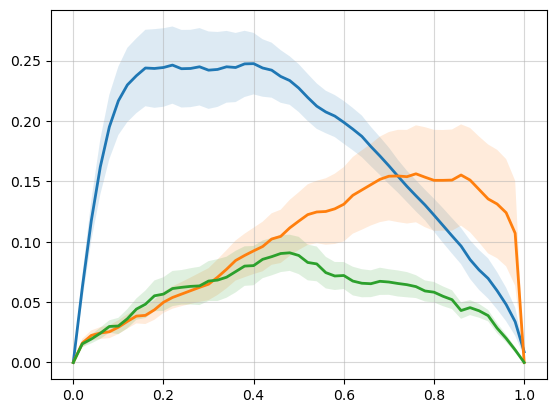

In [5]:
# Getting calibration losses
z = 1.645

post_levels_kl = torch.zeros(100,n_model_kl,n_level)
post_levels_bimp = torch.zeros(100,n_model_bimp,n_level)
post_levels_bgp = torch.zeros(100,n_model_bgp,n_level)

post_levels = [post_levels_kl,post_levels_bimp,post_levels_bgp]


for t in range(trials):
    for m in range(n_model_kl):
        post_levels_kl[:,m] +=  results_kl[trials*m+t]['post_levels']/trials
    for m in range(n_model_bimp):
        post_levels_bimp[:,m] +=  results_bimp[trials*m+t]['post_levels']/trials
    for m in range(n_model_bgp):
        post_levels_bgp[:,m] +=  results_bgp[trials*m+t]['post_levels']/trials
        
cal_loss_kl = (post_levels_kl - levels.T[None]).abs()
cal_loss_bimp = (post_levels_bimp - levels.T[None]).abs()
cal_loss_bgp = (post_levels_bgp - levels.T[None]).abs()

print(cal_loss_kl.mean((0,2)))
print(cal_loss_bimp.mean((0,2)))
print(cal_loss_bgp.mean((0,2)))

plot_inds = 2*torch.arange(51)
model_inds = [[0],[0],[0]]
plt.plot(levels[plot_inds],cal_loss_bgp.mean(0).T[plot_inds][:, model_inds[2]], lw = 2.0);
plt.plot(levels[plot_inds],cal_loss_bimp.mean(0).T[plot_inds][:, model_inds[1]], lw = 2.0);
plt.plot(levels[plot_inds],cal_loss_kl.mean(0).T[plot_inds][:, model_inds[0]], lw = 2.0);

for i in range(n_model_bgp):
    if i in model_inds[2]:
        plt.fill_between(levels[plot_inds][:,0],
                     cal_loss_bgp.mean(0).T[plot_inds,...,i] - z*cal_loss_bgp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss_bgp.mean(0).T[plot_inds,...,i] + z*cal_loss_bgp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.15);
for i in range(n_model_bimp):
    if i in model_inds[1]:
        plt.fill_between(levels[plot_inds][:,0],
                     cal_loss_bimp.mean(0).T[plot_inds,...,i] - z*cal_loss_bimp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss_bimp.mean(0).T[plot_inds,...,i] + z*cal_loss_bimp.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.15);
for i in range(n_model_kl):
    if i in model_inds[0]:
        plt.fill_between(levels[plot_inds][:,0],
                     cal_loss_kl.mean(0).T[plot_inds,...,i] - z*cal_loss_kl.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss_kl.mean(0).T[plot_inds,...,i] + z*cal_loss_kl.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.15);
plt.grid(alpha = 0.5)

In [6]:
# Illustrative plot showing performance differences
result_kl = results_kl[0]
result_bimp = results_bimp[0]
result_bgp = results_bgp[0]




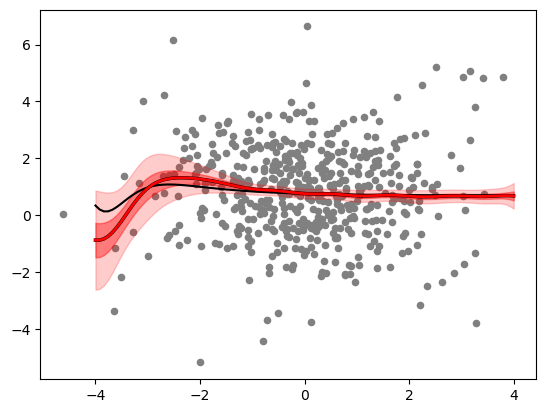

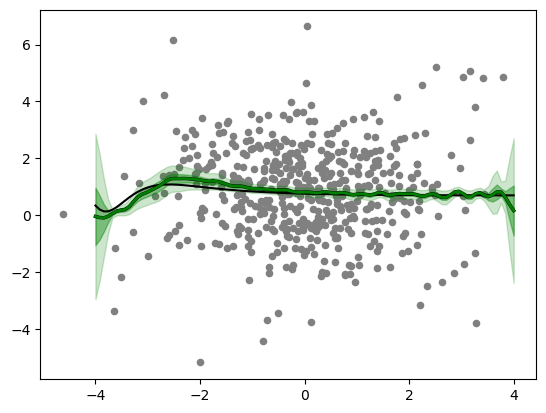

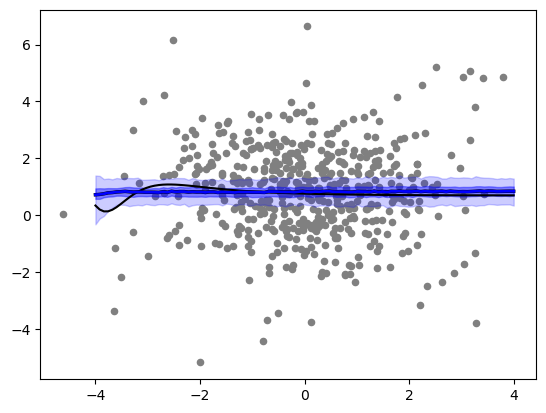

In [7]:
# KL plot
z1 = 1.96
z2 = 0.68

q1 = 0.975
q2 = 0.75

X,Y = result_kl['obs_data']
doX,EYdoX = result_kl['int_data']

plt.scatter(X,Y, color = "grey", s = 20)
plt.plot(doX,EYdoX, color = "black")

mu,var = result_kl['post_moments']
plt.fill_between(doX.view(-1),
                 (mu-z1*var**0.5).view(-1),
                 (mu+z1*var**0.5).view(-1),
                alpha = 0.2, color = "red")
plt.fill_between(doX.view(-1),
                 (mu-z2*var**0.5).view(-1),
                 (mu+z2*var**0.5).view(-1),
                alpha = 0.4, color = "red")
plt.plot(doX,mu, color = "black", lw = 2.5)
plt.plot(doX,mu, color = "red", lw = 2)

plt.show()

# bimp plot
X,Y = result_bimp['obs_data']
doX,EYdoX = result_bimp['int_data']

plt.scatter(X,Y, color = "grey", s = 20)
plt.plot(doX,EYdoX, color = "black")

mu,var = result_bimp['post_moments']
plt.fill_between(doX.view(-1),
                 (mu-z1*var**0.5).view(-1),
                 (mu+z1*var**0.5).view(-1),
                alpha = 0.2, color = "green")
plt.fill_between(doX.view(-1),
                 (mu-z2*var**0.5).view(-1),
                 (mu+z2*var**0.5).view(-1),
                alpha = 0.4, color = "green")
plt.plot(doX,mu, color = "black", lw = 2.5)
plt.plot(doX,mu, color = "green", lw = 2)

plt.show()

# bgp plot
X,Y = result_bgp['obs_data']
doX,EYdoX = result_bgp['int_data']

plt.scatter(X,Y, color = "grey", s = 20)
plt.plot(doX,EYdoX, color = "black")

EYdoX_s = result_bgp['post_samples'][0]
plt.fill_between(doX.view(-1),
                 EYdoX_s.quantile(1-q1,1),
                 EYdoX_s.quantile(q1,1),
                alpha = 0.2, color = "blue")
plt.fill_between(doX.view(-1),
                 EYdoX_s.quantile(1-q2,1),
                 EYdoX_s.quantile(q2,1),
                alpha = 0.4, color = "blue")
plt.plot(doX,EYdoX_s.mean(1), color = "black", lw = 2.5)
plt.plot(doX,EYdoX_s.mean(1), color = "blue", lw = 2)

In [14]:
# Getting regret
iters = len(results_kl[0]['EYdoXeval'])
regret_bo = torch.zeros((trials, n_model_bo))
regret_bgp = torch.zeros((trials, n_model_bgp))
regret_bimp = torch.zeros((trials, n_model_bimp))
regret_kl = torch.zeros((trials, n_model_kl))

regret = [regret_bo,regret_bgp,regret_bimp,regret_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
        for t in range(trials):
            regret[r][t,m] = (best_eval[r][...,t,m]+4.875).sum()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data generation
N = trials  # Number of trials
M = len(n_model)    # Number of models

m_inds = [[0]]*M

# Simulated estimation results as a PyTorch tensor
data_tensor = torch.zeros(N, M)

for r in range(M):
    data_tensor[:,r] = regret[r][:,m_inds[r]][:,0]

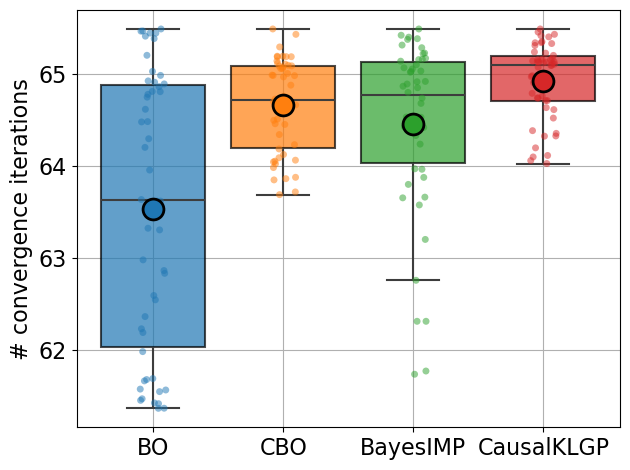

In [16]:
# Convert the tensor to a numpy array and then to a long format for seaborn
data_array = data_tensor.numpy()
data_long = np.vstack([np.column_stack((np.repeat(names[i], N), data_array[:, i])) for i in range(M)])

# Convert the numpy array to appropriate data types for seaborn
models = data_long[:, 0]
estimation_results = data_long[:, 1].astype(float)

# Set up the matplotlib figure
#plt.figure(figsize=(6, 5))

# Use the first four default matplotlib colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:M]

# Overlay a stripplot to show individual data points
sns.stripplot(x=models, y=estimation_results, hue=models, palette=colors, size=5, color='black', alpha=0.5, jitter=True, dodge=False, legend=False)

# Create a box plot with enhanced aesthetics
sns.boxplot(x=models, y=estimation_results, hue=models, palette=colors, linewidth=1.5, fliersize=0, dodge=False, legend=False)

# Add a gradient background
for i in range(M):
    plt.gca().patches[i].set_facecolor(colors[i])
    plt.gca().patches[i].set_edgecolor('black')
    plt.gca().patches[i].set_alpha(0.7)

# Add a title and labels with some styling
plt.ylabel('cumulative regret (10 iterations)', fontsize=16)
# Change grid lines to solid
plt.grid()

# Calculate and label the mean instead of the median
means = [np.mean(estimation_results[models == names[i]]) for i in range(M)]
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color=colors[i], markersize=15, markeredgewidth=2, markeredgecolor='black', zorder = 100)


# Customizing the ticks and spines for a cleaner look
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# Show the plot
plt.tight_layout()
plt.savefig("CBO_box_plot", bbox_inches = "tight")